# Differentiable Optical Models

In the [Optimization Basics](../tutorials/Optimization-Basics.ipynb) tutorial, you learned how to use `x/optym` to do optimization.  In this how-to, you will learn how to make a differentiable optical model using prysm's gradient backpropagation superpowers in order to do optimization-based optical work, such as phase retrieval or coronagraph design.

The idea behind how this works is a technique called gradient backpropagation, or backprop.  With backprop, you write some chain of operations and for each of those operations you know how to compute its derivative.  These derivatives are strung together using the chain rule.  In general, you do not need to know how to do this by hand as most operations in prysm have the backprop rules already coded for you.  There are some reasonable constraints on what is backprop-able, as all of the gradients have been done by hand.  Not all operations are differentiable in the first place, but some algorithms are extremely difficult to derive the backpropagation rules for.  Nevertheless, a wide range of problems can be solved using the rules that have been implemented, or by augmenting prysm with a pull request to introduce new rules.

For this how-to, we will create a _minimum working example_ of how this process works, with some pointers at the bottom of the page that describe how to expand upon this to solve more complicated problems.

We begin with the usual imports, and definition of the high-level system parameters:

In [1]:
import numpy as np

from tqdm import tqdm

from prysm import (
    coordinates,
    geometry,
    polynomials,
    propagation,
    interferogram
)

from prysm.x.optym import mean_square_error, Adam, runN

from matplotlib import pyplot as plt

plt.style.use('bmh')

WF = propagation.Wavefront

In [2]:
# high level system parameters
epd = 10
efl = 100
fno = efl/epd
npup = 256
npsf = 256
wvl = .550

flambd = fno*wvl
dx_psf = flambd / 3  # moderate oversampling

Now we construct our forward model, which serves as both the truth data generator and thing that we optimize.  For this how-to we will do things in a modal (polynomial) manner, but this works just as well in a zonal (per-pixel) manner.

The model can be either a class, or a function; as shown in [Optimization Basics](../tutorials/Optimization-Basics.ipynb), all we need is a function that returns the cost and its gradient.  We'll use a class in this case to cleanly store the non-changing variables, and let us stash intermediate gradients somewhere in case we want to look at them.

In [3]:
class ModalPhaseRetrievalSinglePlane:
    def __init__(self, amp, dx_amp, data, dx_data, efl, wvl, basis):
        self.amp = amp
        self.dx_amp = dx_amp
        self.data = data
        self.dx_data = dx_data
        self.efl = efl
        self.wvl = wvl
        self.basis = basis
        
    def model(self, coefs):
        phs = polynomials.sum_of_2d_modes(self.basis, coefs)
        self.wf = WF.from_amp_and_phase(self.amp, phs, self.wvl, self.dx_amp)
        self.focused = self.wf.focus_fixed_sampling(self.efl, self.dx_data, self.data.shape)
        I = self.focused.intensity
        return I

    def cost_grad(self, coefs):
        I = self.model(coefs).data # I is a RichData, take just the array
        # I contains our model of the system, which we'll compute
        cost, dcost_dI = mean_square_error(I.data, self.data)
        focused_bar = self.focused.intensity_backprop(dcost_dI)
        wf_bar = focused_bar.focus_fixed_sampling_backprop(self.efl, self.dx_amp, self.amp.shape)
        phs_bar = self.wf.from_amp_and_phase_backprop_phase(wf_bar)
        # if you wanted to do a zonal (per-pixel) solver, phs_bar is an ndarray that contains the gradient
        return cost, polynomials.sum_of_2d_modes_backprop(self.basis, phs_bar.data)

    
# grid, polynomial basis
x, y = coordinates.make_xy_grid(npup, diameter=epd)
r, t = coordinates.cart_to_polar(x, y)
dx = x[0,1] - x[0,0]

ap = geometry.circle(epd/2, r)

noll_indices = list(range(4,23))
zernike_nms = [polynomials.noll_to_nm(j) for j in noll_indices]

rnorm = r / (epd/2)
basis = polynomials.zernike_nm_sequence(zernike_nms, rnorm, t, norm=True)

truth_coefs = np.random.rand(len(zernike_nms)) * 25 # in nm RMS
true_I = np.zeros((npsf, npsf))
tmp_model = ModalPhaseRetrievalSinglePlane(ap, dx, true_I, dx_psf, efl, wvl, basis)
true_I = tmp_model.model(truth_coefs).data

optimize_model = ModalPhaseRetrievalSinglePlane(ap, dx, true_I, dx_psf, efl, wvl, basis)

Now that we have created our differentiable model, we initialize an optimizer and let it iterate to find the true coefficients.  In this very simple example,  many aspects of the problem are exactly "aligned," for example there is no error in our understanding of the pupil, no error in our understanding of the PSF scale, the set of Zernikes used to synthesize the truth is identical to the set used in optimization, there is no detector noise, and so on and so on.  We'll use Adam instead of RMSProp, simply tos how that other optimizers are usable, too.

In [4]:
# zero is as good a guess as any
coef0 = np.zeros_like(truth_coefs)
opt = Adam(optimize_model.cost_grad, coef0, 1)  # 1 is alpha, or the global step size variable Adam
max_iter = 1000
f_hist = []
x_hist = []
with tqdm(total=max_iter) as pbar:
    for xk, fk, gk in runN(opt, max_iter):
        fkf = float(fk)  # if you use cupy as a backend, this will be a size 1 vector
        f_hist.append(fkf)
        x_hist.append(xk)
        pbar.set_description(f'Current cost: {fkf:.3g}', refresh=False)
        pbar.update(1)

Current cost: 3.43e-19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.70it/s]


With optimization concluded, we can plot the mean square error over the course of optimization and see:

1.  Did the algorithm converge?
2.  Do we think we could iterate faster by increasing the gain (larger alpha)?

Upon examining the plot below, question (1) is certainly true, and question (2) seems to not matter; given that we got to much less than floating point epsilon error in 11 seconds on the laptop these docs were written on.  The time when readthedocs' servers generate the documentation may be longer.

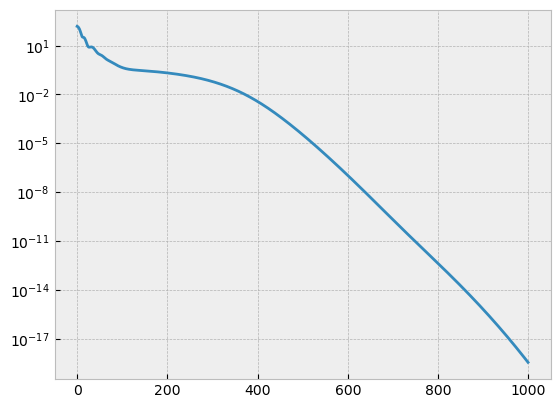

In [5]:
plt.semilogy(f_hist)

Since there is a sign ambiguity in some terms when doing diversity-less phase retrieval and we know the true coefficients, we can compare truth to the retrieved values:

[Text(0.5, 0, 'Noll index'), Text(0, 0.5, 'nm RMS')]

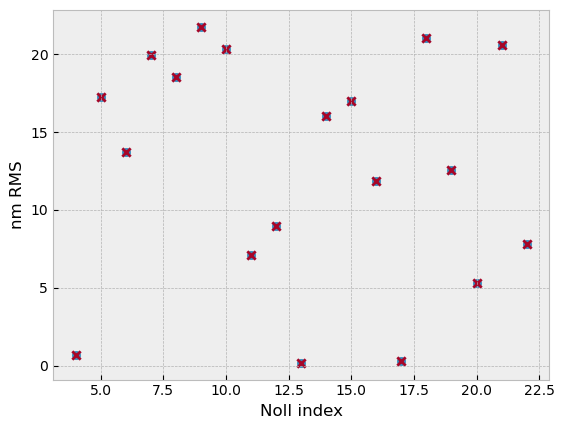

In [6]:
plt.scatter(noll_indices, truth_coefs)
plt.scatter(noll_indices, opt.x, marker='x')
plt.gca().set(xlabel='Noll index', ylabel='nm RMS')

It appears that the true value of all coefficients was retrieved, and no sign ambiguity was encountered.  Because (and only because) the wavefront is exactly zernike coeffiicents, and those coefficients are orthonormal we can evaluate the solution error in terms of RMS wavefront.  We'll plot the per-coefficient error, too:

RMS of estimate error in WFE 2.1741685640859403e-08 nm


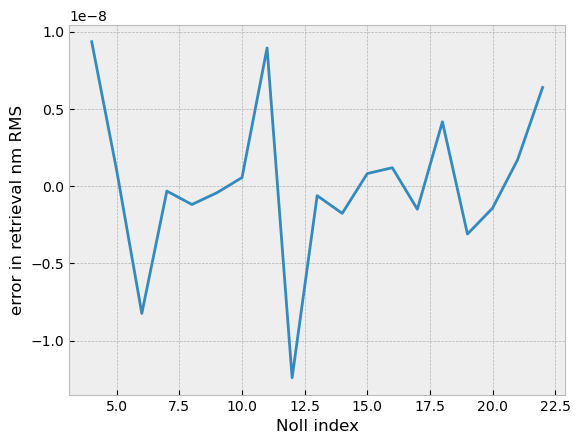

In [7]:
plt.plot(noll_indices, truth_coefs - opt.x)
plt.gca().set(xlabel='Noll index', ylabel='error in retrieval nm RMS')
print('RMS of estimate error in WFE', np.linalg.norm(truth_coefs-opt.x), 'nm')

As a final pair of charts, we can look at each coefficient over the course of optimization and their error:

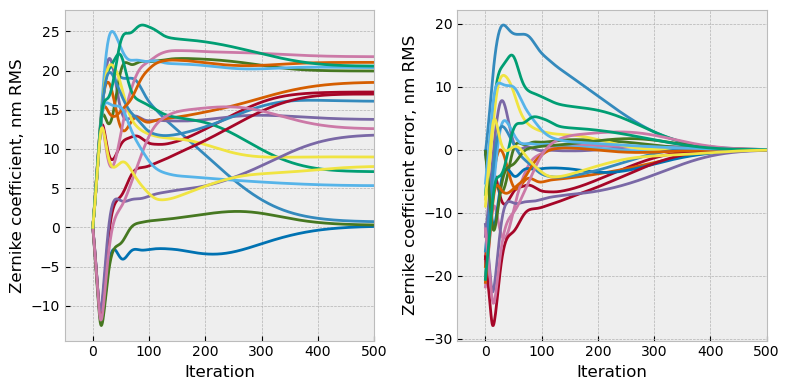

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
axs[0].plot(np.asarray(x_hist))
axs[0].set(xlabel='Iteration', ylabel='Zernike coefficient, nm RMS', xlim=(None,500))
axs[1].plot(np.asarray(x_hist)-truth_coefs)
axs[1].set(xlabel='Iteration', ylabel='Zernike coefficient error, nm RMS', xlim=(None,500))
fig.tight_layout()

Examination of this plot shows that a few terms first went in one direction or had one sign, and later reversed course into the correct sign and true value.  The blend of wavefront error in this problem sufficiently resolved the twin image problem's ambiguity on its own, but this does not always happen.

## Wrap-up

In this how-to, we constructed a differentiable model of an optical system in less than 30 lines of code and used that model to do single-plane phase retrieval via nonlinear optimization.  The logic used here has wide applicability in other areas of optics, as well.  Users wishing to extend this how-to may enjoy the following tips:

1.  To use a zonal solver instead of modal, simply remove the polynomial logic, and insert the optimization variables "x" or "coefs" in the parlance of the model here, directly into an array of zeros and use that as the phase.

2.  If there is diversity, simply sum the cost function over the diversities, and do the same with the gradients in the reverse pass.

3.  A coronagraph can be designed in just the same way as this, with zeros painted in the point spread function where one wishes the dark hole to be